# שלב 5 — מחברת השוואה (Artifacts‑First)

מטרה: לאחד תוצאות מכל השלבים (metrics/topics/examples) לטבלה אחת להשוואה + גרפים + בדיקות תקינות.


In [10]:
import sys
from pathlib import Path

def _add_repo_root():
    cwd = Path.cwd()
    for path in [cwd] + list(cwd.parents):
        if (path / 'project_paths.py').exists():
            sys.path.insert(0, str(path))
            return path
    return cwd

_add_repo_root()

try:
    from google.colab import drive
    drive.mount('/content/drive')
except Exception:
    pass

from project_paths import get_paths

paths = get_paths().ensure()
BASE_DIR = paths.root
DATA_DIR = paths.data_dir
MODELS_DIR = paths.models_dir
RESULTS_DIR = paths.results_dir
RESULTS_ROOT = RESULTS_DIR

print('BASE_DIR  :', BASE_DIR)
print('DATA_DIR  :', DATA_DIR)
print('MODELS_DIR:', MODELS_DIR)
print('RESULTS_DIR:', RESULTS_DIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking for artifacts under: /content/drive/MyDrive/HebrewTopicModel/results_artifacts
Exists? True


## אופציונלי: התקנת תלות (רק אם צריך)
אם אתה מפיק `topics_baselines.csv` מתוך מודלי Gensim (LDA/LSA) — צריך `gensim`.


In [11]:
!pip -q install gensim


## 1) וידוא שקיימים topics לבייסליין (כדי לחשב diversity)
אם אין לך `topics_baselines.csv` — נייצר אותו מתוך המודלים המנצחים ששמרת ל‑Drive.


In [ ]:
import json, pickle

BASELINES_OUT_DIR = RESULTS_ROOT / "baselines"
BASELINES_OUT_DIR.mkdir(parents=True, exist_ok=True)
topics_baselines_path = BASELINES_OUT_DIR / "topics_baselines.csv"
print("topics_baselines_path:", topics_baselines_path)

if topics_baselines_path.exists():
    print("✅ topics_baselines.csv already exists — skipping generation")
else:
    SAVE_DIR = MODELS_DIR / "stage3_baselines"
    print("SAVE_DIR:", SAVE_DIR, "exists?", SAVE_DIR.exists())

    rows = []

    # --- LDA / LSA (gensim) ---
    from gensim.models import LdaModel, LsiModel

    for model_path in SAVE_DIR.glob("*.gensim"):
        base = model_path.name.replace(".gensim", "")
        meta_path = SAVE_DIR / (base + "__meta.json")

        dataset = None
        if meta_path.exists():
            meta = json.loads(meta_path.read_text(encoding="utf-8"))
            dataset = meta.get("dataset", None) or meta.get("Dataset", None)

        if dataset is None and "__" in base:
            parts = base.split("__")
            if len(parts) >= 3:
                dataset = f"{parts[1]}:{parts[2]}"
        if dataset is None:
            dataset = "UNKNOWN"

        if base.startswith("LDA"):
            model = LdaModel.load(str(model_path))
            for topic_id in range(model.num_topics):
                words = [w for w,_ in model.show_topic(topic_id, topn=12)]
                rows.append({"model":"LDA","dataset":dataset,"topic_id":topic_id,"top_terms":", ".join(words),"topic_size":np.nan})

        elif base.startswith("LSA") or base.startswith("LSI"):
            model = LsiModel.load(str(model_path))
            for topic_id in range(model.num_topics):
                pairs = model.show_topic(topic_id, topn=36)
                pairs = sorted(pairs, key=lambda x: abs(x[1]), reverse=True)[:12]
                words = [w for w,_ in pairs]
                rows.append({"model":"LSA","dataset":dataset,"topic_id":topic_id,"top_terms":", ".join(words),"topic_size":np.nan})

    # --- NMF (pickle bundle) ---
    for pkl_path in SAVE_DIR.glob("*.pkl"):
        base = pkl_path.name.replace(".pkl", "")
        meta_path = SAVE_DIR / (base + "__meta.json")

        dataset = None
        if meta_path.exists():
            meta = json.loads(meta_path.read_text(encoding="utf-8"))
            dataset = meta.get("dataset", None) or meta.get("Dataset", None)

        if dataset is None and "__" in base:
            parts = base.split("__")
            if len(parts) >= 3:
                dataset = f"{parts[1]}:{parts[2]}"
        if dataset is None:
            dataset = "UNKNOWN"

        bundle = pickle.loads(pkl_path.read_bytes())
        nmf = bundle["nmf"]
        vectorizer = bundle["vectorizer"]
        terms = vectorizer.get_feature_names_out()

        for topic_id, comp in enumerate(nmf.components_):
            idx = np.argsort(comp)[::-1][:12]
            words = [terms[i] for i in idx]
            rows.append({"model":"NMF","dataset":dataset,"topic_id":topic_id,"top_terms":", ".join(words),"topic_size":np.nan})

    topics_baselines = pd.DataFrame(rows)
    print("topics_baselines rows:", len(topics_baselines))
    display(topics_baselines.head())

    topics_baselines.to_csv(topics_baselines_path, index=False)
    print("✅ saved:", topics_baselines_path)


## 2) איתור וטעינת ארטיפקטים (metrics/topics/examples)
כאן חשוב: `glob` מחפש את כל הקבצים, אבל אם אתה מציג רק `[:5]` תראה “כאילו לא נקראו כולם”.
בנוסף: אם קובץ נכשל בקריאה, הוא עדיין יופיע ברשימת `*_files` — לכן נציג גם `failed_files`.


In [13]:
def _read_csv_safely(path: Path) -> tuple[pd.DataFrame, str|None]:
    try:
        return pd.read_csv(path), None
    except Exception as e:
        return pd.DataFrame(), str(e)

def find_files(root: Path, pattern: str):
    return [Path(p) for p in glob.glob(str(root / "**" / pattern), recursive=True)]

metrics_files  = find_files(RESULTS_ROOT, "metrics_*.csv")
topics_files   = find_files(RESULTS_ROOT, "topics_*.csv")
examples_files = find_files(RESULTS_ROOT, "examples_*.csv")

print("Found metrics :", len(metrics_files))
print("Found topics  :", len(topics_files))
print("Found examples:", len(examples_files))

# show a small sample only (the list contains ALL)
print("Sample metrics files:", metrics_files[:3])


Found metrics : 4
Found topics  : 4
Found examples: 3
Sample metrics files: [PosixPath('/content/drive/MyDrive/HebrewTopicModel/results_artifacts/metrics_baselines.csv'), PosixPath('/content/drive/MyDrive/HebrewTopicModel/results_artifacts/metrics_top2vec.csv'), PosixPath('/content/drive/MyDrive/HebrewTopicModel/results_artifacts/metrics_ctm.csv')]


## 3) איחוד סכמות וטעינה ל‑3 טבלאות


In [14]:
METRICS_REQUIRED = ["model", "dataset", "num_topics"]
METRICS_OPTIONAL  = ["coherence_cv", "topic_diversity", "platform", "stage", "notes"]

TOPICS_REQUIRED = ["model", "dataset", "topic_id", "top_terms", "topic_size"]
TOPICS_OPTIONAL = []

EXAMPLES_REQUIRED = ["model", "dataset", "topic_id", "doc_text_short"]
EXAMPLES_OPTIONAL = ["doc_id"]

def standardize_columns(df: pd.DataFrame) -> pd.DataFrame:
    rename_map = {
        "num_topic": "num_topics",
        "n_topics": "num_topics",
        "coherence_c_v": "coherence_cv",
        "topic_div": "topic_diversity",
    }
    return df.rename(columns={c: rename_map.get(c, c) for c in df.columns})

def ensure_columns(df: pd.DataFrame, required, optional):
    df = standardize_columns(df)
    for c in required:
        if c not in df.columns:
            df[c] = np.nan
    for c in optional:
        if c not in df.columns:
            df[c] = np.nan
    return df

def add_source_cols(df: pd.DataFrame, path: Path) -> pd.DataFrame:
    df = df.copy()
    df["_source_file"] = str(path)
    df["_source_dir"]  = str(path.parent)
    return df

def load_many(paths, required, optional):
    dfs, failed = [], []
    for p in paths:
        df, err = _read_csv_safely(p)
        if err is not None:
            failed.append((str(p), err))
            continue
        if df.empty:
            continue
        df = ensure_columns(df, required, optional)
        df = add_source_cols(df, p)
        dfs.append(df)
    out = pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame(columns=required+optional)
    return out, failed

metrics_all, metrics_failed   = load_many(metrics_files,  METRICS_REQUIRED,  METRICS_OPTIONAL)
topics_all, topics_failed     = load_many(topics_files,   TOPICS_REQUIRED,   TOPICS_OPTIONAL)
examples_all, examples_failed = load_many(examples_files, EXAMPLES_REQUIRED, EXAMPLES_OPTIONAL)

print("Loaded metrics rows :", len(metrics_all), "| failed files:", len(metrics_failed))
print("Loaded topics rows  :", len(topics_all),  "| failed files:", len(topics_failed))
print("Loaded examples rows:", len(examples_all),"| failed files:", len(examples_failed))

if metrics_failed:
    print("Example metrics read error:", metrics_failed[0])

display(metrics_all.head())


Loaded metrics rows : 43 | failed files: 0
Loaded topics rows  : 343 | failed files: 0
Loaded examples rows: 567 | failed files: 0


,stage,platform,model,dataset,num_topics,coherence_cv,topic_diversity,notes,_source_file,_source_dir
0,3,colab,LDA,Wiki:clean_text,10,0.332618,NaN,NaN,/content/drive/MyDrive/HebrewTopicModel/results_artifacts/metrics_baselines.csv,/content/drive/MyDrive/HebrewTopicModel/results_artifacts
1,3,colab,LDA,Wiki:clean_text,20,0.360077,NaN,NaN,/content/drive/MyDrive/HebrewTopicModel/results_artifacts/metrics_baselines.csv,/content/drive/MyDrive/HebrewTopicModel/results_artifacts
2,3,colab,LDA,Wiki:clean_text,30,0.371794,NaN,NaN,/content/drive/MyDrive/HebrewTopicModel/results_artifacts/metrics_baselines.csv,/content/drive/MyDrive/HebrewTopicModel/results_artifacts
3,3,colab,LDA,Wiki:lemma_text,10,0.464471,NaN,NaN,/content/drive/MyDrive/HebrewTopicModel/results_artifacts/metrics_baselines.csv,/content/drive/MyDrive/HebrewTopicModel/results_artifacts
4,3,colab,LDA,Wiki:lemma_text,20,0.498580,NaN,NaN,/content/drive/MyDrive/HebrewTopicModel/results_artifacts/metrics_baselines.csv,/content/drive/MyDrive/HebrewTopicModel/results_artifacts


## 4) סיכום מדדים ודירוג מאוחד
אנחנו מאחדים תוצאות לפי (model, dataset).
`topic_diversity_final` נלקח מה‑artifact אם קיים, אחרת מחושב מ‑`topics_*.csv` על בסיס 12 המילים המובילות לכל נושא.
`largest_topic_share` מחושב רק כשיש `topic_size` (CTM / Top2Vec / C‑Top2Vec).
בייסליין (LDA/LSA/NMF) לא מייצא גדלי נושאים → אין קנס דומיננטיות.

דירוג סופי:
`score_final = coherence_cv * topic_diversity_final`
`score_penalized = score_final * (1 - largest_topic_share)` (כשזמין)

**הערה:** הציון מיועד לדירוג פנימי בלבד; אין להשוות ציון בין קורפוסים שונים בלי זהירות.


In [27]:
# numeric conversions
for c in ["num_topics", "coherence_cv", "topic_diversity"]:
    if c in metrics_all.columns:
        metrics_all[c] = pd.to_numeric(metrics_all[c], errors="coerce")

topics_all["topic_size"] = pd.to_numeric(topics_all["topic_size"], errors="coerce")

# base summary from metrics (one row per model+dataset)
grouped = metrics_all.groupby(["model","dataset"], dropna=False)
summary = grouped.agg(
    runs=("model","count"),
    num_topics=("num_topics","median"),
    coherence_cv=("coherence_cv","mean"),
    topic_diversity=("topic_diversity","mean"),
).reset_index()

# diversity from topics (works also for baselines once topics_baselines.csv exists)
def topic_diversity_from_topics(df, top_words=12):
    tmp = df.copy()
    tmp["words"] = tmp["top_terms"].fillna("").apply(
        lambda s: [w.strip() for w in s.split(",")[:top_words] if w.strip()]
    )
    grp = tmp.groupby(["model","dataset"])["words"].apply(list).reset_index()
    out = []
    for _, r in grp.iterrows():
        words = [w for lst in r["words"] for w in lst]
        div = (len(set(words)) / len(words)) if words else np.nan
        out.append({"model": r["model"], "dataset": r["dataset"], "topic_diversity_calc": div})
    return pd.DataFrame(out)

div_df = topic_diversity_from_topics(topics_all, top_words=12)

# dominance (largest_topic_share) from topic sizes
dom = (topics_all.groupby(["model","dataset"], dropna=False)["topic_size"]
       .agg(total="sum", largest="max")
       .reset_index())

# avoid division by 0 or NaN totals
dom["largest_topic_share"] = np.where(dom["total"] > 0, dom["largest"] / dom["total"], np.nan)

summary2 = (
    summary
    .merge(div_df, on=["model","dataset"], how="left")
    .merge(dom[["model","dataset","largest_topic_share"]], on=["model","dataset"], how="left")
)

# final diversity: prefer metrics diversity, else calc from topics
summary2["topic_diversity_final"] = summary2["topic_diversity"].fillna(summary2["topic_diversity_calc"])

# dominance penalty: if largest_topic_share missing (baselines) -> no penalty (=1)
summary2["dominance_penalty"] = (1 - summary2["largest_topic_share"]).fillna(1.0).clip(0.0, 1.0)

summary2["score_final"] = summary2["coherence_cv"] * summary2["topic_diversity_final"]
summary2["score_penalized"] = summary2["score_final"] * summary2["dominance_penalty"]

# sort per dataset by penalized score (NaN goes last automatically)
display(summary2.sort_values(["dataset","score_penalized"], ascending=[True, False], na_position="last"))


,model,dataset,runs,num_topics,coherence_cv,topic_diversity,topic_diversity_calc,largest_topic_share,topic_diversity_final,dominance_penalty,score_final,score_penalized
1,CTM,UGC,1,12.0,0.609762,0.819444,0.819444,0.125516,0.819444,0.874484,0.499666,0.436950
11,NMF,UGC:clean_text,3,10.0,0.369168,NaN,0.722222,NaN,0.722222,1.000000,0.266622,0.266622
7,LSA,UGC:clean_text,3,10.0,0.406920,NaN,0.453125,NaN,0.453125,1.000000,0.184386,0.184386
3,LDA,UGC:clean_text,3,10.0,0.474544,NaN,0.338235,NaN,0.338235,1.000000,0.160508,0.160508
15,Top2Vec,UGC:clean_text,1,2.0,0.400592,0.833333,0.833333,0.884072,0.833333,0.115928,0.333826,0.038700
12,NMF,UGC:lemma_text,3,10.0,0.427098,NaN,0.902778,NaN,0.902778,1.000000,0.385574,0.385574
4,LDA,UGC:lemma_text,3,10.0,0.406206,NaN,0.541667,NaN,0.541667,1.000000,0.220028,0.220028
8,LSA,UGC:lemma_text,3,10.0,0.423816,NaN,0.500000,NaN,0.500000,1.000000,0.211908,0.211908
16,Top2Vec,UGC:lemma_text,1,2.0,0.252238,0.833333,0.833333,0.982346,0.833333,0.017654,0.210198,0.003711
2,CTM,Wiki,1,20.0,0.748777,0.920833,0.920833,0.064723,0.920833,0.935277,0.689499,0.644873


,dataset,model,runs,num_topics,coherence_cv,topic_diversity_final,largest_topic_share,dominance_penalty,score_final,score_penalized
0,Wiki,CTM,1,20.0,0.748777,0.920833,0.064723,0.935277,0.689499,0.644873
1,Wiki:lemma_text,NMF,3,20.0,0.686662,0.875000,NaN,1.000000,0.600829,0.600829
2,Wiki:clean_text,NMF,3,20.0,0.633494,0.869444,NaN,1.000000,0.550788,0.550788
3,UGC,CTM,1,12.0,0.609762,0.819444,0.125516,0.874484,0.499666,0.436950
4,UGC:lemma_text,NMF,3,10.0,0.427098,0.902778,NaN,1.000000,0.385574,0.385574
5,Wiki:lemma_text,LDA,3,20.0,0.481851,0.637500,NaN,1.000000,0.307180,0.307180
6,Wiki_clean_text_v2,C-Top2Vec,1,120.0,0.456658,0.695833,0.060696,0.939304,0.317758,0.298471
7,UGC:clean_text,NMF,3,10.0,0.369168,0.722222,NaN,1.000000,0.266622,0.266622
8,Wiki:clean_text,LSA,3,20.0,0.411167,0.605042,NaN,1.000000,0.248773,0.248773
9,UGC:lemma_text,LDA,3,10.0,0.406206,0.541667,NaN,1.000000,0.220028,0.220028


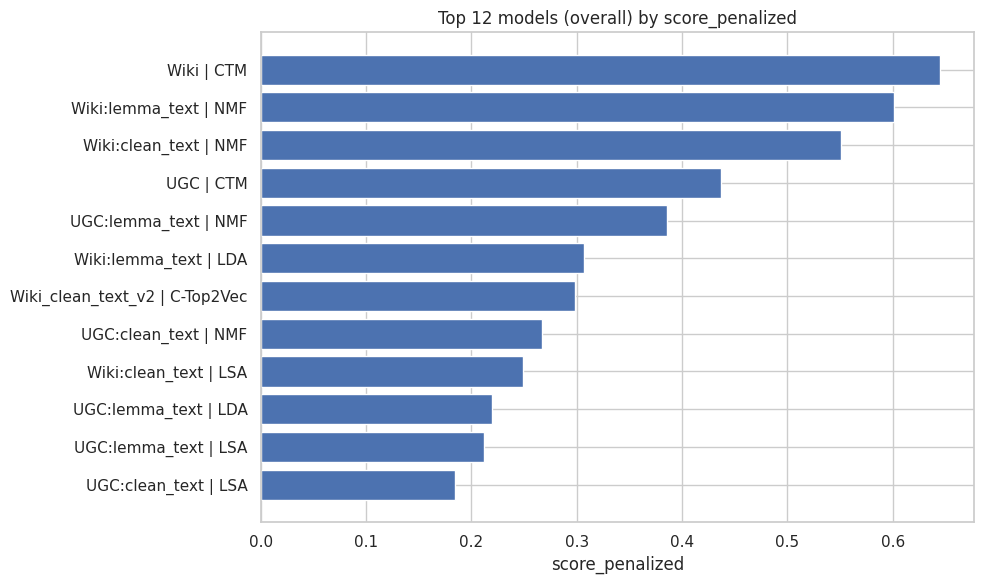

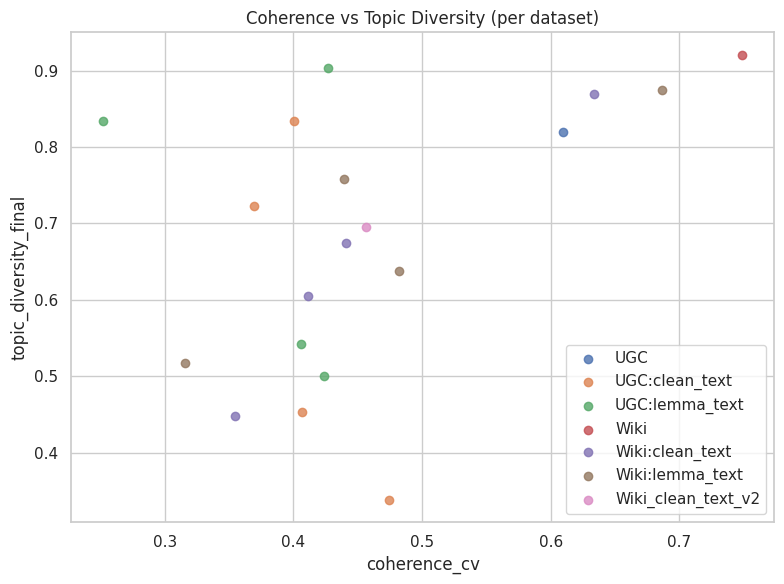

In [38]:
df = summary2.copy()

# ensure numeric (for safe sorting/plotting)
for c in ["num_topics","coherence_cv","topic_diversity_final","largest_topic_share",
          "dominance_penalty","score_final","score_penalized"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

final_cols = [
    "dataset","model","runs","num_topics",
    "coherence_cv","topic_diversity_final",
    "largest_topic_share","dominance_penalty",
    "score_final","score_penalized"
]

final_global = (df[final_cols]
    .sort_values(by=["score_penalized","coherence_cv"], ascending=[False, False], na_position="last")
    .reset_index(drop=True)
)

display(final_global)

# ---------- plots (same cell) ----------
import matplotlib.pyplot as plt

# (1) Top-N overall by score_penalized
topN = 12
plot_df = final_global.head(topN).copy()
plot_df["label"] = plot_df["dataset"].astype(str) + " | " + plot_df["model"].astype(str)

plt.figure(figsize=(10, 6))
plt.barh(plot_df["label"][::-1], plot_df["score_penalized"][::-1])
plt.xlabel("score_penalized")
plt.title(f"Top {topN} models (overall) by score_penalized")
plt.tight_layout()
plt.show()

# (2) Coherence vs Diversity scatter (colored by dataset automatically)
plt.figure(figsize=(8, 6))
for ds, g in df.dropna(subset=["coherence_cv","topic_diversity_final"]).groupby("dataset"):
    plt.scatter(g["coherence_cv"], g["topic_diversity_final"], label=str(ds), alpha=0.8)

plt.xlabel("coherence_cv")
plt.ylabel("topic_diversity_final")
plt.title("Coherence vs Topic Diversity (per dataset)")
plt.legend(loc="best")
plt.tight_layout()
plt.show()


## 5) בחירת המודל הטוב לכל Dataset (לשקף)
כאן אנחנו בוחרים את המודל הטוב לפי `score_penalized` לכל dataset.


## מגבלות ההשוואה
- קורפוסים שונים (Wiki מול UGC) → סקאלה שונה של Coherence.
- מודלים שונים שומרים ארטיפקטים באופן שונה ולכן חלק מהמדדים משוערים.
- תמיד לשלב גם בדיקה איכותית לצד הציון המספרי.


In [41]:
best = (summary2
        .sort_values(["dataset","score_penalized"], ascending=[True, False], na_position="last")
        .groupby("dataset", as_index=False)
        .head(1)
        .sort_values("score_penalized", ascending=False, na_position="last")
       )

best_view = best[[
    "dataset","model","num_topics",
    "coherence_cv","topic_diversity_final",
    "largest_topic_share","dominance_penalty",
    "score_penalized"
]].copy()

best_view["coherence_cv"] = best_view["coherence_cv"].round(3)
best_view["topic_diversity_final"] = best_view["topic_diversity_final"].round(3)
best_view["largest_topic_share"] = best_view["largest_topic_share"].round(3)
best_view["dominance_penalty"] = best_view["dominance_penalty"].round(3)
best_view["score_penalized"] = best_view["score_penalized"].round(3)

display(best_view)


,dataset,model,num_topics,coherence_cv,topic_diversity_final,largest_topic_share,dominance_penalty,score_penalized
2,Wiki,CTM,20.0,0.749,0.921,0.065,0.935,0.645
14,Wiki:lemma_text,NMF,20.0,0.687,0.875,NaN,1.000,0.601
13,Wiki:clean_text,NMF,20.0,0.633,0.869,NaN,1.000,0.551
1,UGC,CTM,12.0,0.610,0.819,0.126,0.874,0.437
12,UGC:lemma_text,NMF,10.0,0.427,0.903,NaN,1.000,0.386
0,Wiki_clean_text_v2,C-Top2Vec,120.0,0.457,0.696,0.061,0.939,0.298
11,UGC:clean_text,NMF,10.0,0.369,0.722,NaN,1.000,0.267


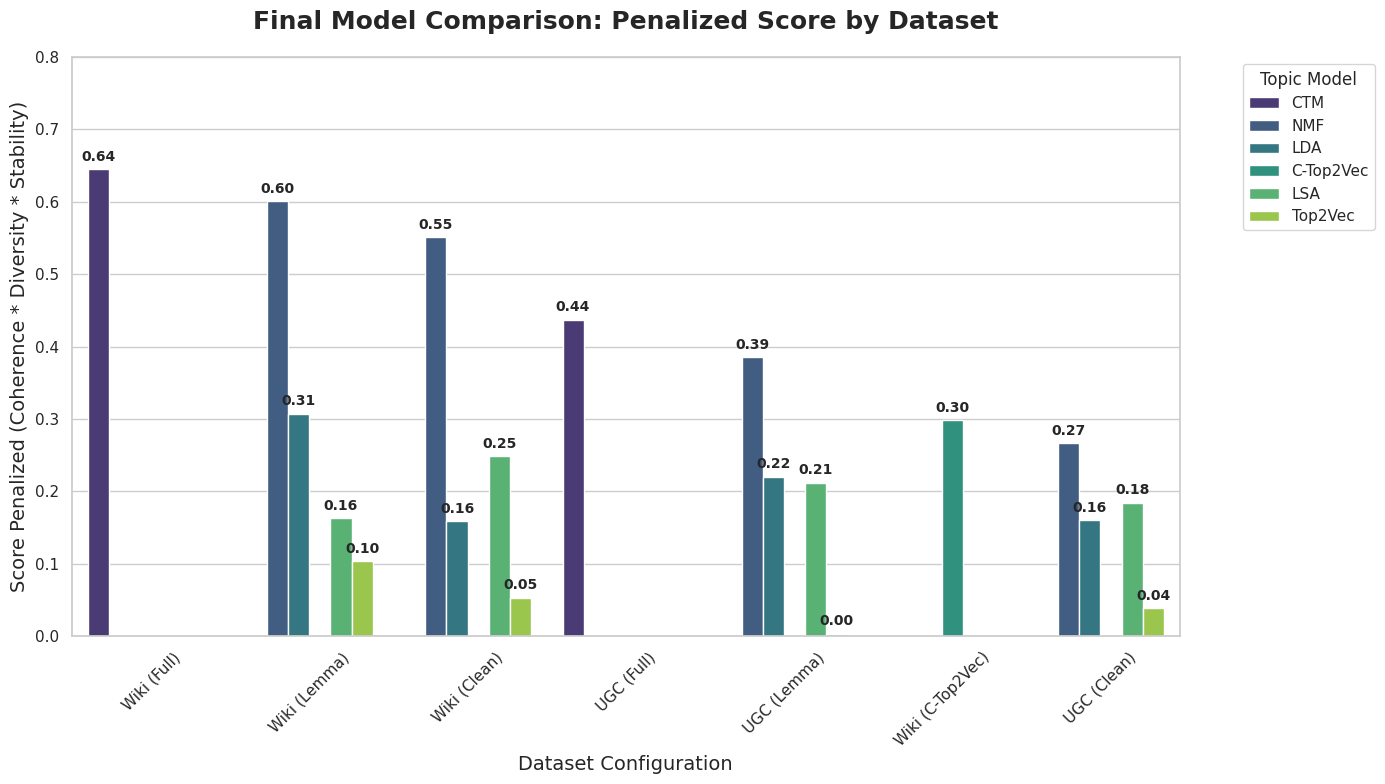

## 6) כלי בדיקה איכותנית (topics + examples)
בחר מודל+דאטה ותראה: נושאים גדולים + דוגמאות למסמך.


In [52]:
def show_largest_topics(model: str, dataset: str, top_k: int = 10):
    df = topics_all[(topics_all["model"] == model) & (topics_all["dataset"] == dataset)].copy()
    if df.empty:
        print("No topics found for", model, dataset)
        return None
    df = df.sort_values("topic_size", ascending=False).head(top_k)
    display(df[["topic_id","topic_size","top_terms"]])
    return df


def show_examples(model: str, dataset: str, topic_id: int, n: int = 3):
    df = examples_all[
        (examples_all["model"] == model) &
        (examples_all["dataset"] == dataset) &
        (examples_all["topic_id"] == topic_id)
    ].copy()
    if df.empty:
        print("No examples found for", model, dataset, "topic", topic_id)
        return
    # אם יש לך score/relevance בעמודה כלשהי, אפשר למיין לפיה. אם לא — נשאיר כמו שזה.
    display(df.head(n)[["doc_id","doc_text_short"]])


print("Models:", sorted(set(summary2["model"].dropna().unique())))
print("Datasets:", sorted(set(summary2["dataset"].dropna().unique())))


Models: ['C-Top2Vec', 'CTM', 'LDA', 'LSA', 'NMF', 'Top2Vec']
Datasets: ['UGC', 'UGC:clean_text', 'UGC:lemma_text', 'Wiki', 'Wiki:clean_text', 'Wiki:lemma_text', 'Wiki_clean_text_v2']


In [58]:
MODEL = "CTM"
DATASET = "Wiki"

top_df = show_largest_topics(MODEL, DATASET, top_k=5)  # אם לא החזרת DF, פשוט תראה את הטבלה ותבחר topic_id ידנית

# אם עדכנת show_largest_topics שתחזיר DF:
topic_id = int(top_df.iloc[0]["topic_id"])
print("Selected topic_id:", topic_id)
show_examples(MODEL, DATASET, topic_id=topic_id, n=3)

# טופיק שני בגודלו
topic_id2 = int(top_df.iloc[1]["topic_id"])
print("Second topic_id:", topic_id2)
show_examples(MODEL, DATASET, topic_id=topic_id2, n=2)



,topic_id,topic_size,top_terms
56,19,1618.0,"סרט, פרס, אנגלית, ספר, סופר, אמריקאי, קולנוע, סדרה, עלילה, סיפור, אוסקר, רומן"
55,18,1580.0,"מלך, אירוע, לוח, מוות, קיסר, נשאר, סיום, הסטורי, שני, שושלת, שליט, רומי"
43,6,1548.0,"אדם, תחום, מונח, מדע, מחקר, תאוריה, פילוסופיה, חברתי, חקר, עוסק, אנושי, מושג"
50,13,1514.0,"נולד, אוניברסיטה, ביוגרפיה, לימוד, שנה, תואר, ישראלי, לימד, למד, אביב, אב, סיים"
53,16,1495.0,"מלחמה, צבא, גרמני, חיל, עולם, ברית, קרב, נאצי, צבאי, מהלך, גרמנייה, טנק"


Selected topic_id: 19


,doc_id,doc_text_short
168,2102,"ג ואן רולינג באנגלית , שם המשפחה מבוטא רָוְולִינְג נולדה ב ביולי , המוכרת בשם העט ג יי. קיי. רולינג . . , היא סופרת ופילנתרופית בריטית י..."
169,8573,"לה גווין עם הרלן אליסון במפגש סופרי מדע בדיוני במערב ארצות הברית, אורסולה קרובר לה גווין באנגלית באוקטובר בינואר הייתה סופרת אמריקאית, א..."
170,13295,פרס נבולה באנגלית הוא פרס ספרותי שניתן כל שנה מטעם אגודת סופרי המדע הבדיוני והפנטזיה של אמריקה לכותבי סיפורי המדע הבדיוני הטובים ביותר ש...


Second topic_id: 18


,doc_id,doc_text_short
165,23500,"שמאל הכתרת לואי השמיני ובלאנש מקסטיליה בלנקה, נסיכת קסטיליה במרץ בנובמבר , הידועה גם בשם הצרפתי בלאנש, הייתה אשתו של לואי השמיני ואמו של..."
166,15589,"פסל של ג יימס השני בכיכר טרפלגר בלונדון. ג יימס השני, מלך אנגליה או ג יימס השביעי, מלך סקוטלנד באוקטובר בספטמבר היה מלך אנגליה, סקוטלנד ..."


In [59]:
MODEL = "CTM"
DATASET = "UGC"

top_df = show_largest_topics(MODEL, DATASET, top_k=5)
topic_id = int(top_df.iloc[0]["topic_id"])
print("Selected topic_id:", topic_id)
show_examples(MODEL, DATASET, topic_id=topic_id, n=3)

# טופיק שני בגודלו
topic_id2 = int(top_df.iloc[1]["topic_id"])
print("Second topic_id:", topic_id2)
show_examples(MODEL, DATASET, topic_id=topic_id2, n=2)


,topic_id,topic_size,top_terms
68,11,639.0,"ספרד, מבלי, תאוריה, קרס, חולון, מדבר, חיוב, לאלתר, ערוך, כינס, תקין, קטלני"
60,3,609.0,"תאוריה, ספרד, מבלי, פגישה, קרס, לאלתר, השתגע, חולון, תקין, מתייחס, מר, שערורייה"
59,2,483.0,"ביבי, נתניהו, בחירה, ראש, בנט, נאשם, גנץ, שוחד, אמון, משפט, הצביע, מושחת"
57,0,470.0,"מחלה, קורונה, מת, חיסון, וירוס, שפעת, נגיף, תרופה, עולם, ריאה, קשה, נפטר"
62,5,445.0,"כבוד, הצלחה, מקסים, יפה, מעולה, אישה, אוהב, אהבה, מאוד, יישר, מצוין, מרגש"


Selected topic_id: 11


,doc_id,doc_text_short
204,2261,לא סתם הם רופאים צעירים
205,3402,קתולים ממש לא שורפים גופות
206,4344,זה לא קצר זה מולד...


Second topic_id: 3


,doc_id,doc_text_short
180,854,בנט ליצן . סמוטריץ ולא בעד סיפוח.
181,2654,מה קורה עם בלוק הימין? אין בו יותר צורך אז מכפישים את ימינה


## C‑Top2Vec (Wiki_clean_text_v2) — בדיקה איכותנית (נושאים מובילים + דוגמאות)

אנו מציגים את 5 הטופיקים הגדולים ביותר לפי `topic_size`.

לאחר מכן בוחנים דוגמאות מסמכים מתוך שני הטופיקים הגדולים (topic_id=0 ו‑topic_id=1) כדי לוודא התאמה בין `top_terms` לבין תוכן הטקסט.

במקרה זה, שני הטופיקים הגדולים עוסקים בנושאים “ויקיפדיה כלליים/אנציקלופדיים” (נראים כטופיק‑על), ולכן חשוב לציין שקיים סיכון ל‑dominance (טופיק גדול שמכסה חלק משמעותי מהקורפוס).

מסיבה זו בדירוג הסופי השתמשנו גם ב‑`largest_topic_share` וב‑`dominance_penalty` כדי לאזן מול מודלים שנוטים להתכנס לטופיקים גדולים מדי.


In [61]:
MODEL = "C-Top2Vec"
DATASET = "Wiki_clean_text_v2"

top_df = show_largest_topics(MODEL, DATASET, top_k=5)
topic_id = int(top_df.iloc[0]["topic_id"])
print("Selected topic_id:", topic_id)
show_examples(MODEL, DATASET, topic_id=topic_id, n=3)

# טופיק שני בגודלו
topic_id2 = int(top_df.iloc[1]["topic_id"])
print("Second topic_id:", topic_id2)
show_examples(MODEL, DATASET, topic_id=topic_id2, n=2)


,topic_id,topic_size,top_terms
69,0,124640.0,"עיצור, נהוג, נהגה, נהוגה, בהגייה, נוהג, נהגו, ההגייה, נהגית, יג, בפולנית, ליג"
70,1,67346.0,"נבחרתו, בעונתו, באליפות, האליפות, ליגת, שיחק, במוקדמות, המצטיין, לטורניר, שחקני, שיחקו, הקונפדרציה"
71,2,59219.0,"כינוי, שפירושה, בשמות, כתובות, הונגרית, קברות, סמלים, אתניות, שמות, ילידים, אותיות, בתעתיק"
72,3,58957.0,"ניצחונו, האירים, מרד, בוכנוואלד, נסוגו, אנטיגונוס, המונגולים, להביס, וולדמורט, נלחמו, נור, משטרו"
73,4,50139.0,"עיטור, מדליית, הפרס, צלב, אביר, הצלב, תוארו, עיטורים, לודוויג, בוכנוואלד, הזכייה, הארד"


Selected topic_id: 0


,doc_id,doc_text_short
207,864,סו ית נקראת ית אנ ית שפה סלאבית מערבית מתוך קבוצת השפות הסלאביות שבמשפחת השפות ההודו אירופיות דוברי הסורבית הסורבים צאצאי הוונדים השבט ה...
208,3561,ולשית בוולשית באנגלית שפה ממשפחת השפות הקלטיות זוהי השפה הרשמית השנייה בבריטניה לצד האנגלית ולשית השפה הקלטית הנפוצה ביותר אחרי ברטונית ...
209,64,נוסח תפילה יהודי נודע הנאמר בארמית בבלית עיקרו הקדיש בקשה להתגדלות ולהתקדשות שמו האל והתגלות מלכותו בעולם במרבית הנוסחים מופיעה בקשה לקי...


Second topic_id: 1


,doc_id,doc_text_short
210,1219,עומר גולן נולד באוקטובר כדורגלן עבר ישראלי ששיחק בעמדת החלוץ מלך השערים קבוצת מכבי פתח תקווה בכל הזמנים וכיום המנהל הספורטיבי והמנכ המוע...
211,2328,נבחרת ספרד בכדורגל לגברים בספרדית נבחרת הכדורגל הלאומית ספרד ומייצגת מאז תקופת השיא נבחרת ספרד כללה זכייה פעמיים ברציפות באליפות אירופה ...


## ניתוח שגיאות (איכותני)
- זוהו נושאים עם טוקנים הכוללים סימני פיסוק/סיומות (למשל `שבאנגליה.`), מה שמצביע על ניקוי לא מלא של טקסט ויכול לפגוע בקוהרנטיות.
- במסמכי UGC קצרים מאוד יש ערבוב נושאים בגלל מחסור בהקשר (שורה/שתיים בלבד).
- יש דומיננטיות של ישויות (מקומות/קבוצות/שמות) שמטשטשת נושאים סמנטיים.

השלכות ושיפורים מוצעים:
- חיזוק נירמול פיסוק וגרסאות מורפולוגיות לפני מודלים מבוססי embeddings.
- סינון/איחוד מסמכים קצרים במיוחד ב‑UGC או שימוש ב‑lemma_text בלבד.
- שימוש במודלים מתקדמים (CTM/C‑Top2Vec) שיפור קוהרנטיות לעומת הבייסליין, אך עדיין נדרש ניקוי ייעודי לטוקנים רועשים.


## ניתוח שגיאות (דוגמאות קונקרטיות)
- Top2Vec, `Wiki:clean_text`, topic 0 מערבב תכנים לא קשורים (ביוגרפיה של סופר פנטזיה, היסטוריה קולוניאלית, ומגדל בבל) — סימן לסטייה נושאית (topic drift).
- Top2Vec, `UGC:clean_text`, topic 0 כולל רנט על קורונה לצד תגובת ספורט — ערבוב בגלל מסמכי UGC קצרים.
